IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



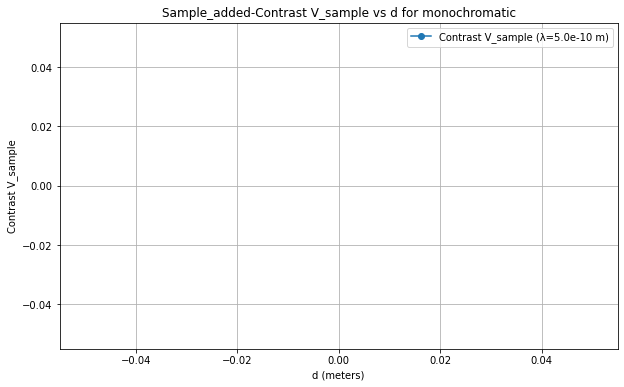

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

# Define parameters
pi = np.pi
alpha = pi / 2
p_G = 2.4E-6  # Grating period in meters
x_1 = 0
L_1 = 2  # meters
lam = 5E-10  # Wavelength in meters
L = 4  # meters  # Distance between last grating and camera, in meters
h = 15E-6
N = 5.0E28
b = 4.1491E-15
L_s = L / 3

# Define slit size
slit_size = 240E-6  # Slit size in meters

# Function to calculate contrast V and K_max for a given d and lambda
def calculate_contrast_s_and_kmax(d, lam):
    p_s = p_G
    k_0 = 2 * pi / lam
    k_G = 2 * pi / p_G
    k_s = 2 * pi / p_s
    L_2s = L - L_1 - d - L_s
    pm = L * p_G / d  # Moiré period
    k_m = 2 * pi / pm  # Moiré wave vector
    M1 = 1 + d / L_1  # First magnification
    M2s = 1 + L_2s / (L_1 + d)  # Second magnification with sample
    M3 = 1 + L_s / (L_1 + d + L_2s)  # Third magnification with sample

    m_max = 5  # Maximum absolute value of m (odd)

    # Function definitions
    def generate_G1(m_max, k_G, x_1, alpha=np.pi / 4):
        G1 = []  # Initialize G1 as an empty list
        G1.append([0, np.cos(N * b * lam * h / 2)])
        m_values = [m for m in range(-m_max, m_max + 1) if m % 2 != 0]
        for m in m_values:
            wave_vector = m * k_G
            amplitude = (2 / (m * pi)) * np.sin(N * b * lam * h / 2) * np.exp(1j * m * k_G * x_1)
            G1.append([wave_vector, amplitude])
        return G1

    def custom_convolution(P1, G1):
        P2 = []
        for row in G1:
            wave_vector, amplitude = row
            result = (P1[0] + wave_vector, P1[1] * amplitude)
            P2.append(result)
        return P2

    def scale_wave_vectors(P2, M1):
        P2n = [(wave_vector / M1, amplitude) for wave_vector, amplitude in P2]
        return P2n

    def phaseterm(P2n, d, k_0, M1):
        P3 = [
            (
                wave_vector,
                np.exp(-1j * d * (wave_vector**2) / (2 * (k_0 / M1))) * amplitude
            )
            for wave_vector, amplitude in P2n
        ]
        return P3

    def custom_convolution2(P3, G1):
        P4 = []
        for p3_row in P3:
            wave_vector_p3, amplitude_p3 = p3_row
            for g1_row in G1:
                wave_vector_g1, amplitude_g1 = g1_row
                result2 = (wave_vector_p3 + wave_vector_g1, amplitude_p3 * amplitude_g1)
                P4.append(result2)
        return P4

    def scale_wave_vectors2(P4, M1, M2s):
        P4n = [(wave_vector / M2s, amplitude) for wave_vector, amplitude in P4]
        return P4n

    def phaseterm2(P4n, d, k_0, M1, M2s):
        P5 = [
            (
                wave_vector,
                np.exp(-1j * L_2s * ((wave_vector**2) / (2 * (k_0 / (M1 * M2s)))) / M1) * amplitude
            )
            for wave_vector, amplitude in P4n
        ]
        return P5

    def generate_Gs1(m_max, k_s, pi):
        Gs1 = []
        Gs1.append([0, np.cos((pi)/2)])
        m_values = [m for m in range(-m_max, m_max + 1) if m % 2 != 0]
        for m in m_values:
            wave_vector = m * k_G
            amplitude = (2 / (m * pi)) * np.sin((pi)/2)
            Gs1.append([wave_vector, amplitude])
        return Gs1

    def custom_convolution3(P5, Gs1):
        P6 = []
        for p5_row in P5:
            wave_vector_p5, amplitude_p5 = p5_row
            for gs1_row in Gs1:
                wave_vector_gs1, amplitude_gs1 = gs1_row
                result3 = (wave_vector_p5 + wave_vector_gs1, amplitude_p5 * amplitude_gs1)
                P6.append(result3)
        return P6

    def scale_wave_vectors3(P6, M1, M2s, M3):
        P6n = [(wave_vector / M3, amplitude) for wave_vector, amplitude in P6]
        return P6n

    def phaseterm3(P6n, d, k_0, M1, M2s, M3):
        P7 = [
            (
                wave_vector,
                np.exp(-1j * L_s * ((wave_vector**2) / (2 * (k_0 / (M1 * M2s * M3)))) /(M1 * M2s)) * amplitude
            )
            for wave_vector, amplitude in P6n
        ]
        return P7

    def compute_P7_conj(P7):
        P7_conj = []
        for wave_vector, amplitude in P7:
            first_term_conj = -wave_vector
            second_term_conj = np.conj(amplitude)
            P7_conj.append((first_term_conj, second_term_conj))
        return P7_conj

    def H_sample_convolution_4(P7, P7_conj):
        H_sample = []
        for P7_row in P7:
            wave_vector_P7, amplitude_P7 = P7_row
            for P7_conj_row in P7_conj:
                wave_vector_P7_conj, amplitude_P7_conj = P7_conj_row
                result4_sample = (wave_vector_P7 + wave_vector_P7_conj, amplitude_P7 * amplitude_P7_conj)
                H_sample.append(result4_sample)
        return H_sample
        

    # Generate G1
    G1 = generate_G1(m_max, k_G, x_1)

    # Perform custom convolution to get P2
    P1 = [0, 1]  # Initial conditions for convolution
    P2 = custom_convolution(P1, G1)

    # Scale wave vectors to get P2n
    P2n = scale_wave_vectors(P2, M1)

    # Apply phase term to get P3
    P3 = phaseterm(P2n, d, k_0, M1)

    # Perform second convolution to get P4
    P4 = custom_convolution2(P3, G1)

    # Scale wave vectors to get P4n
    P4n = scale_wave_vectors2(P4, M1, M2s)

    # Apply phase term to get P5
    P5 = phaseterm2(P4n, d, k_0, M1, M2s)

    # Perform third convolution to get P6
    Gs1 = generate_Gs1(m_max, k_s, pi)

    P6 = custom_convolution3(P5, Gs1)

    # Scale wave vectors to get P6n
    P6n = scale_wave_vectors3(P6, M1, M2s, M3)

    # Apply phase term to get P7
    P7 = phaseterm3(P6n, d, k_0, M1, M2s, M3)

    # Compute conjugate of P7
    P7_conj = compute_P7_conj(P7)

    # Perform convolution to get H
    H_sample = H_sample_convolution_4(P7, P7_conj)
    print("H_sample",H_sample)

    # Aggregate similar wave vectors and their amplitudes
    def aggregate_amplitudes_sample(H_sample):
        wave_vector_sums = {}
        for wave_vector, amplitude in H_sample:
            rounded_wave_vector = np.round(wave_vector, 1)
            if rounded_wave_vector in wave_vector_sums:
                wave_vector_sums[rounded_wave_vector] += amplitude
            else:
                wave_vector_sums[rounded_wave_vector] = amplitude
        H_sample_reduced = [(wave_vector, amplitude) for wave_vector, amplitude in wave_vector_sums.items()]
        return H_sample_reduced

    # Get H_reduced
    H_sample_reduced = aggregate_amplitudes_sample(H_sample)

    # Find max amplitude in the region of 0.9k_m to 1.1k_m and its wave vector
    def find_max_amplitude_and_wave_vector(H_sample_reduced, k_m):
        max_ampl = 0
        k_max = 0
        for wave_vector, amplitude in H_sample_reduced:
            if 0.9 * k_m <= wave_vector <= 1.1 * k_m:
                if amplitude > max_ampl:
                    max_ampl = amplitude
                    k_max = wave_vector
        return max_ampl, k_max

    # Find max amplitude at zero wave vector
    def find_H0_sample(H_sample_reduced):
        H_0_sample = 0
        for wave_vector, amplitude in H_sample_reduced:
            if wave_vector == 0:
                H_0_sample = amplitude
                break
        return H_0_sample

    # Calculate Max_ampl, K_max, and H_0
    Max_ampl, K_max = find_max_amplitude_and_wave_vector(H_sample_reduced, k_m)
    H_0_sample = find_H0_sample(H_sample_reduced)

    # Calculate sinc functions for the slit size
    sinc_km = np.sinc(k_m * slit_size / (2 * pi))
    sinc_H0_sample = np.sinc(H_0_sample * slit_size / (2 * pi)) if H_0_sample != 0 else 0

    # Calculate contrast V_sample
    V_sample = np.abs(2 * Max_ampl * sinc_km / (H_0_sample * sinc_H0_sample)) if H_0_sample != 0 else None
    return V_sample, K_max

# Range for d
d_range = np.arange(0.011, 0.013, 0.001)  # Range for d values

# Create dictionary to store V_sample for different d values
V_sample_dict = {}

# Store results to avoid recalculating
results = [calculate_contrast_s_and_kmax(d, lam) for d in d_range]

# Store V_sample in the dictionary, ignoring values below 1% contrast
V_sample_dict[lam] = {d: result[0] for d, result in zip(d_range, results) if result[0] >= 0.01}

# Print the V_sample dictionary
#print("V_sample dictionary:")
#print(f"\nFor wavelength λ = {lam:.1e} m:")
for d, V_sample in V_sample_dict[lam].items():
    print(f"d = {d:.4f} m, V_sample = {V_sample:.4f}")

# Save results to a CSV file, only including values above the 1% threshold
csv_filename = 'V_withsample_phi_filtered.csv'
contrast_data = []

for d, result in zip(d_range, results):
    V_sample, K_max = result
    if V_sample >= 0.01:
        contrast_data.append([d, V_sample])

with open(csv_filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['d (m)', 'V_sample'])
    csvwriter.writerows(contrast_data)

#print(f'Results saved to {csv_filename}')

# Plot Contrast V_sample vs d
fig, ax1 = plt.subplots(figsize=(10, 6))

# Retrieve results for the lambda
contrast_sample_values = [result[0] for result in results if result[0] >= 0.01]

# Plot contrast vs d on the primary y-axis
ax1.plot(d_range[:len(contrast_sample_values)], contrast_sample_values, marker='o', linestyle='-', label=f'Contrast V_sample (λ={lam:.1e} m)')

# Add labels and legend
ax1.set_xlabel('d (meters)')
ax1.set_ylabel('Contrast V_sample')
ax1.set_title('Sample_added-Contrast V_sample vs d for monochromatic')
ax1.legend(loc='upper right')
ax1.grid(True)

#plt.show()
